In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [3]:
seq_length = 7 # 7일을 보고 예측
data_dim = 5 # 시가, 최고가, 최저가, 거래량, 종가
hidden_dim = 10 
output_dim = 1 # 종가 예측
learning_rate = 0.01
iterations = 500

In [4]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data 0~1 사이로
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

 [0.81714539 0.81469361 0.85719795 0.13477637 0.8491804 ]] -> [0.81795327]
[[0.76273745 0.75545421 0.79648285 0.17037734 0.76838408]
 [0.7466256  0.76777165 0.78144725 0.16836067 0.80464554]
 [0.77353624 0.77808167 0.8132009  0.13959846 0.80834206]
 [0.78436956 0.80683358 0.83890473 0.15226315 0.82928929]
 [0.81014161 0.82854227 0.86600435 0.16614681 0.84034382]
 [0.81714539 0.81469361 0.85719795 0.13477637 0.8491804 ]
 [0.81266032 0.81231195 0.83006228 0.18480774 0.81795327]] -> [0.83002868]
[[0.7466256  0.76777165 0.78144725 0.16836067 0.80464554]
 [0.77353624 0.77808167 0.8132009  0.13959846 0.80834206]
 [0.78436956 0.80683358 0.83890473 0.15226315 0.82928929]
 [0.81014161 0.82854227 0.86600435 0.16614681 0.84034382]
 [0.81714539 0.81469361 0.85719795 0.13477637 0.8491804 ]
 [0.81266032 0.81231195 0.83006228 0.18480774 0.81795327]
 [0.79264985 0.7982932  0.82673301 0.14341669 0.83002868]] -> [0.85495413]
[[0.77353624 0.77808167 0.8132009  0.13959846 0.80834206]
 [0.78436956 0.806833

In [6]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.2271038442850113
1 0.18340937793254852
2 0.15106438100337982
3 0.12612313032150269
4 0.10598734766244888
5 0.08915018290281296
6 0.07493706792593002
7 0.06327901780605316
8 0.054496027529239655
9 0.04902385547757149
10 0.04693441092967987
11 0.04731706529855728
12 0.04838264361023903
13 0.04839478060603142
14 0.04633767157793045
15 0.04207771271467209
16 0.03620169684290886
17 0.029662011191248894
18 0.02338656224310398
19 0.018011242151260376
20 0.013800662942230701
21 0.010714654810726643
22 0.008532220497727394
23 0.0069765071384608746
24 0.005824481602758169
25 0.004987422842532396
26 0.004524713382124901
27 0.0045546842738986015
28 0.005089898593723774
29 0.005920968484133482
30 0.006684893276542425
31 0.00707267364487052
32 0.006973990239202976
33 0.006471904926002026
34 0.005753521807491779
35 0.005014693830162287
36 0.004395292606204748
37 0.003953744191676378
38 0.003676638938486576
39 0.00351098389364779
40 0.0034013083204627037
41 0.0033151074312627316
42 0.0032488945871

336 0.0014310459373518825
337 0.00142950052395463
338 0.001427961396984756
339 0.0014264287892729044
340 0.0014249018859118223
341 0.0014233817346394062
342 0.0014218675205484033
343 0.0014203597093001008
344 0.0014188578352332115
345 0.0014173618983477354
346 0.0014158724807202816
347 0.001414389000274241
348 0.0014129113405942917
349 0.00141143926884979
350 0.0014099737163633108
351 0.0014085139846429229
352 0.00140706030651927
353 0.0014056123327463865
354 0.0014041704125702381
355 0.0014027345459908247
356 0.0014013040345162153
357 0.0013998799258843064
358 0.0013984612887725234
359 0.0013970490545034409
360 0.001395642408169806
361 0.0013942418154329062
362 0.0013928473927080631
363 0.0013914587907493114
364 0.0013900760095566511
365 0.001388699747622013
366 0.0013873294228687882
367 0.0013859651517122984
368 0.0013846071669831872
369 0.0013832554686814547
370 0.0013819102896377444
371 0.0013805713970214128
372 0.0013792390236631036
373 0.0013779131695628166
374 0.0013765940675511

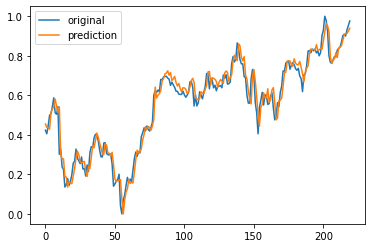

In [7]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()